# Tutorial for the ParametricSequencer

The ParametricSequencer is a virtual instrument that facilitates the control of an AWG. The basic principle of the sequencer is that it takes a single template element that is defined with symbols and creates a sequence from it by replicating it for different values for selected symbols. For example a template element could define a rectangular pulse with a certain amplitude defined through the symbol 'amplitude'. For given setpoints `('amplitude', [0.1, 0.2, 0.3])`  the parametric sequencer would create a sequence of three elements, all being rectangular pulses but with the given different amplitudes.

### Sequence Parameters
Furthermore one can use a template element that has further symbols, like 'pulse_duration' in the aforementioned example. These symbols become available as qcodes parameters and can be get and set. When setting one of those parameters the sequence gets updated and reuploaded.

### Repetition and Seqeunce Modes and Setpoint Parameters
The sequencer can be operated in three different `sequence_mode`s: 'sequence', 'element', and 'inner'.
<br>
- In 'sequence' mode the whole sequence is run.<br>
- In 'element' mode, only a single element is run. For the selection of the single element the sequencer also provides qcodes parameters. Here a 'set'-command does not cause a reupload but simply a jump to the element that relises the requested parameters (more precisely: to the element that has a value closest to the requested value).
- The 'inner' mode is not implemented yet. It is relevant when we have two sets of setpoints, whose tensor product defines the parameter grid and we want to repeat a certain row of inner setpoints in that space.
<br>
The sequencer can be operated in two different `repetition_mode`s: 'single', and 'inf'.
<br>
- In 'single' mode the sequence/element is run once when the run function is called.<br>
- In 'inf' mode, the sequence/element is run on a loop infinitely

### AWG interface
The communication with the awgs is abstracted into an awg interface. This notebook can be run without an AWG present by using the SimulatedAWGInterface that simply plots the resulting actions. For real instruments, so far there is only an interface for a AWG5014.

## Example
Lets take a look at some example code.

Lets first setup the AWG and the interface:

In [1]:
def print_params(instr):
    print(instr.name.upper())
    for k, v in instr.parameters.items():
        if k != 'IDN':
            print(k, ': ', v())
    for k, v in instr.submodules.items():
        if isinstance(v, InstrumentBase):
            print('\n')
            print_params(v)

In [2]:
real_instrument_present = False

In [3]:
import numpy as np
from copy import copy
from lomentum import Segment, SegmentGroup, Element, Sequence
from lomentum.atoms import sine, ramp, flat, zero, marker_on, marker_off
from lomentum.plotting import plotter

from qdev_wrappers.customised_instruments.composite_instruments.parametric_sequencer.parametric_sequencer import ParametricSequencer
from qdev_wrappers.customised_instruments.interfaces.AWG_interface import AWG5014Interface, SimulatedAWGInterface
from qcodes.instrument.base import InstrumentBase, Instrument

/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/logger.py:16: UserWarning: The logger.py of qdev-wrappers is deprecated and will be removed soon. Please use the logger of QCoDeS instead.
  warnings.warn('The logger.py of qdev-wrappers is deprecated and will be '


In [4]:
if real_instrument_present:
    from qdev_wrappers.station_configurator import StationConfigurator
    sc = StationConfigurator()
    awg = sc.load_instrument('AWG5014')
    awg.clock_freq(1e7)    
    awg_if = AWG5014Interface('real_awg', awg=awg)
else:
    awg_if = SimulatedAWGInterface('simulated_awg')

The following example uses a template element similar to the one used in the Broadbean (v1) Tutorial. It produces a centered pi pulse and a marker with a given delay:

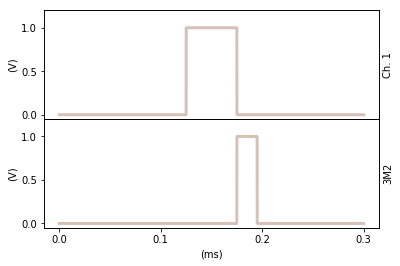

In [5]:
seg1 = zero(duration='flex_time')
seg2 = flat(duration='pulse_duration', amplitude='pulse_amplitude')
seg3 = zero(duration='flex_time')

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration='total_duration')

m1 = marker_off(duration='pre_marker_time')
m2 = marker_on(duration='marker_time')
m3 = marker_off(duration='post_marker_time')

markers = SegmentGroup(m1, m2, m3,
                       duration='total_duration')

def mytransformation(context):
    context['flex_time'] = 0.5*(context['total_duration'] - context['pulse_duration'])
    context['pre_marker_time'] = context['flex_time'] + context['marker_delay']
    context['post_marker_time'] = context['total_duration'] - context['marker_time'] - context['pre_marker_time']

template_element = Element(segments={1: pi_pulse,
                                     '3M2': markers},
                           sequencing={'nrep':2},
                           transformation=mytransformation)

context = {'total_duration': 3e-4,
           'marker_time': 2e-5,
           'marker_delay': 5e-5,
           'pulse_duration': 0.5e-4,
           'pulse_amplitude': 1}

pulse_durations = np.linspace(0e-4,2.9e-4,3)

inner_setpoints = ('pulse_duration', pulse_durations)

plotter(template_element, context=context, SR=awg_if.sample_rate())

As setpoints we want to use the pulse duration. The marker (lower row) will be automatically adjusted.

Next, let us create the ParametricSequencer providing it with the awg interface, the template, the setpoints and the context:

In [6]:
try:
    ps = Instrument.find_instrument('PS')
    ps.close()
except KeyError:
    pass
ps = ParametricSequencer(name='PS', awg=awg_if)

The sequencer repetition mode and sequence mode mirror those of the awg

In [7]:
print_params(ps)
print_params(awg_if)

PS
sequence_mode :  sequence
repetition_mode :  inf


PS_SEQUENCE_PARAMETERS


PS_REPEAT_PARAMETERS
SIMULATED_AWG
sample_rate :  1000000000.0
sequence_mode :  sequence
repetition_mode :  inf
sleep_time :  0


SIMULATED_AWG_CH0
Vpp :  1


SIMULATED_AWG_CH1
Vpp :  1


SIMULATED_AWG_CH2
Vpp :  1


SIMULATED_AWG_CH3
Vpp :  1


Lets upload a sequence by calling `change_sequence`:

uploading
running


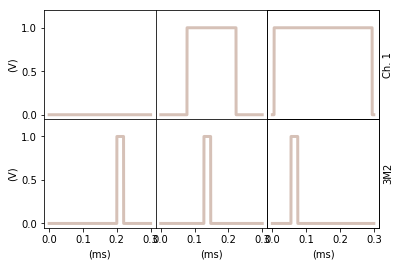

In [8]:
ps.change_sequence(template_element=template_element,
                   context=context,
                   inner_setpoints=inner_setpoints)

As expected we got a sequence with three different pulse durations.

The sequence can be changed in parts:

uploading
running


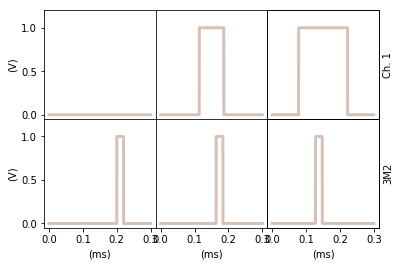

In [9]:
ps.change_sequence(inner_setpoints=('pulse_duration', 0.5 * np.linspace(0e-4, 2.9e-4, 3)))

uploading
running


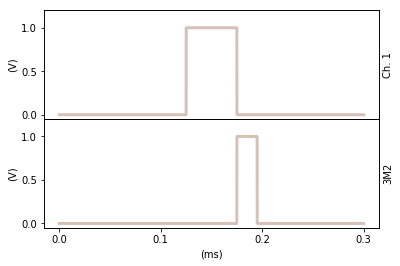

In [10]:
ps.change_sequence(inner_setpoints=None)

uploading
running


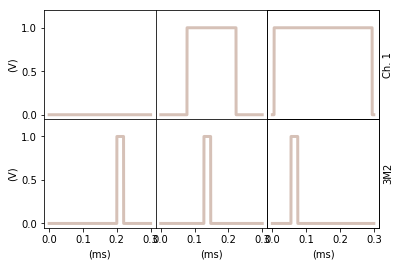

In [11]:
ps.change_sequence(inner_setpoints=inner_setpoints)


### Sequence Parameters

The sequence parameters, as provided in the context, are exposed in the channel 'sequence':

In [12]:
ps.sequence.parameters

{'total_duration': <qcodes.instrument.parameter.Parameter: total_duration at 4804552912>,
 'marker_time': <qcodes.instrument.parameter.Parameter: marker_time at 4887154192>,
 'marker_delay': <qcodes.instrument.parameter.Parameter: marker_delay at 4887282016>,
 'pulse_duration': <qcodes.instrument.parameter.Parameter: pulse_duration at 4887282184>,
 'pulse_amplitude': <qcodes.instrument.parameter.Parameter: pulse_amplitude at 4887282352>}

The sequence can be modified via those parameters, causing a new sequence to be uploaded, for example lets increase the marker duration:

uploading
running


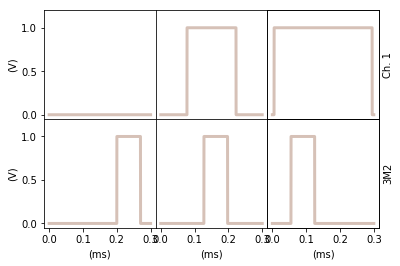

In [13]:
ps.sequence.marker_time(7e-5)

### The single_upload Context Manager

For each change of parameters the sequence is uploaded. To avoid this long process a context manager can be used to have a single upload even though multiple parameters are changed: (only one plot appears)

uploading
running


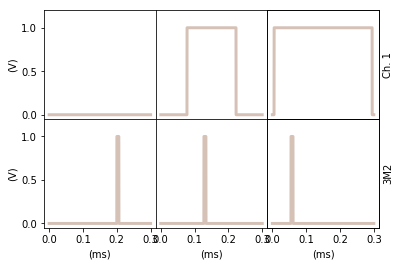

In [14]:
with ps.single_upload():
    ps.sequence.marker_delay(5e-5)
    ps.sequence.marker_time(6e-6)

### Element Sequence Mode

So far we have always run the full sequence but one can now try changing to 'element' sequence mode. Without having specified an element, the first element will be repeated:

setting sequence_mode to element
setting element to 0
running


/Users/natalie/Documents/PhD/Qdev/lomentum/lomentum/plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])


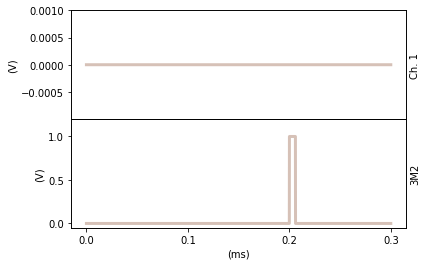

In [15]:
ps.sequence_mode('element')

You can change to a different element of the sequence by changing the value of the repeat parameter(s). The sequencer will warn you if the exact value is not in the sequence and will go to the element with the nearest value and tell you that value.

/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/customised_instruments/composite_instruments/parametric_sequencer/parametric_sequencer.py:356: UserWarning: Rounding setpoint value from 0.0001 to 0.000145.
  warn(f'Rounding setpoint value from {value} to '


setting element to 1
running


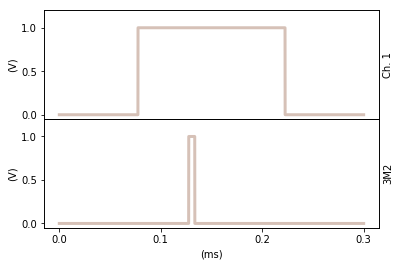

In [16]:
ps.repeat.pulse_duration(1e-4)

Switch between sequence mode and element mode remembers the current step:

setting sequence_mode to sequence
running
setting sequence_mode to element
setting element to 1
running


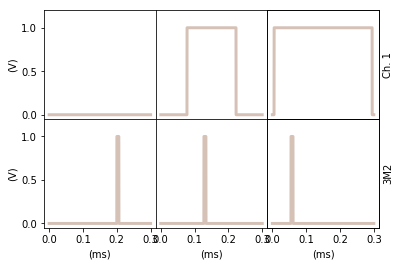

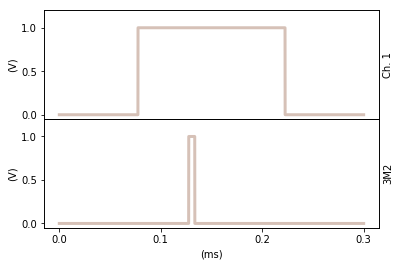

In [17]:
ps.sequence_mode('sequence')
ps.sequence_mode('element')

If the sequence mode is 'sequence' and the value of a repeat parameter is changed the effect will be to leave the sequence running but when the mode is next changed to 'element' the corresponding element will play.

setting sequence_mode to sequence
running
setting sequence_mode to element
setting element to 0
running


/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/customised_instruments/composite_instruments/parametric_sequencer/parametric_sequencer.py:239: UserWarning: Warning: setting the inner setpoints to while being in sequence mode
  warn(f"Warning: setting the {['outer', 'inner'][set_inner]} "


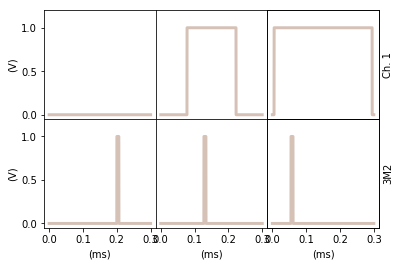

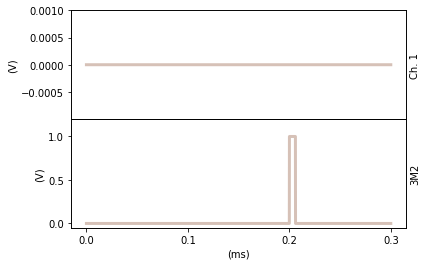

In [18]:
ps.sequence_mode('sequence')
# expect a warning here
ps.repeat.pulse_duration(0)
ps.sequence_mode('element')

### Single Repetition Mode

We have so far always played the element/sequence on an infinite loop but it is also possible to play it only once if the repetition mode is changed to 'single'. The awg will then wait until run is called to run the sequence/element.

In [19]:
ps.repetition_mode('single')

setting repetition_mode to single


In [20]:
ps.run()

running


### First and initial elements

There are currently two ways of adding an initial element, the first is to use the initial_element kwarg which prepends this template_element to the sequence, the second is to us the first_sequence_element kwarg which replaces the first element of the sequence. 

setting sequence_mode to sequence
setting repetition_mode to inf
running


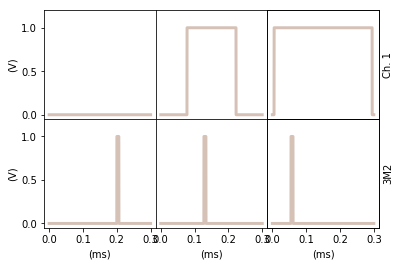

In [21]:
ps.sequence_mode('sequence')
ps.repetition_mode('inf')

uploading
running


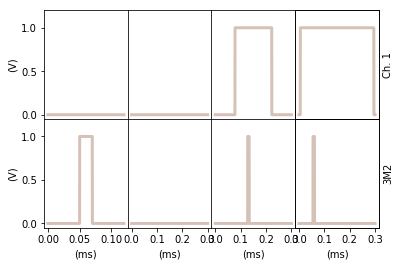

In [22]:
first_element = copy(template_element)
first_element.segments['3M2'] = marker_off(duration='total_duration')
initial_element = Element(segments={1: zero(duration='total_duration'),
                                    '3M2': markers},
                          local_context={'pre_marker_time':5e-5,
                                         'marker_time':2e-5,
                                         'post_marker_time':5e-5,
                                         'total_duration':12e-5})

ps.change_sequence(initial_element=initial_element,
                   first_sequence_element=first_element)

So we see 1+3 elements (initial_element, first_element, sequence[1], sequence[2]). Setting the parameters works as expected.

setting sequence_mode to element
setting element to 2
running


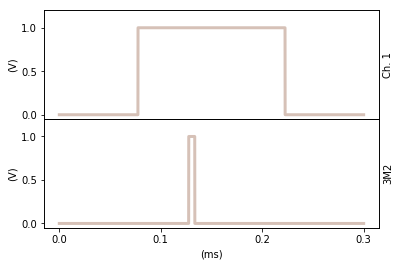

In [23]:
ps.repeat.pulse_duration(1e-4)
ps.sequence_mode('element')

## 2D sequence
Here is a slightly more complicated example with inner and outer setpoints, resulting into a 2D sequence.
Furthermore an initial segment is specified, that gets prepended to the sequence and is not included in the stepping. There is also another new keyword argument: 'first_element' which enables to specify a different first element of the series (as requested). In contrast to the initial element, will this first element be included in the stepping

setting sequence_mode to sequence
running


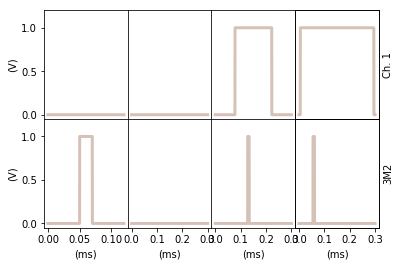

In [24]:
ps.sequence_mode('sequence')

uploading
running


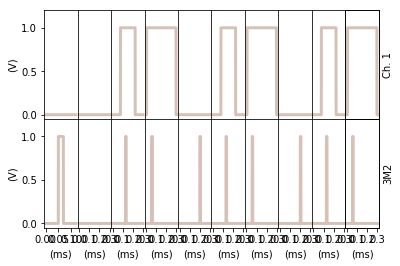

In [25]:
ps.change_sequence(inner_setpoints=('pulse_duration', pulse_durations),
                   outer_setpoints=('pulse_amplitudes', [0, 0.5, 1]))

As expected we see a sequence with 9+1 elements. The very first element only has the marker and the second one is missing the marker.


We can step to an element that is now defined by the set of inner and outer setpoints. Here there is not yet any context manager to minimize the communication overhead and the awg will make 3 steps: (the error messag is due to plotting a signal with zero amplitude)

## Next Steps
- get the 'inner repeat mode' to work and
- consider the possible ways of extending to keyword like paramters, e.g. storing different gates, that can be addressed by their name.
- ability to reprogramm the order of the setpoints without uploading, so that a gate sequence can be created. Or possibly extend so that many sequences can be uploaded to the awg and switching between them is allowed. This would minimise upload time

I am happy about any kind of feedback!